In [1]:
import torch
print(torch.__version__)

2.5.1+cu121


In [2]:
!python --version

Python 3.10.12


In [3]:
from google.colab import drive
# Mount the Google Drive to access files stored there
drive.mount('/content/drive')

# Install the latest version of torchtext library quietly without showing output
# !pip install torchtext -qq
!pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##
basepath = '/content/drive/MyDrive/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login


In [5]:
set_seed(42)

In [6]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import login
from google.colab import userdata
login(token="your token")

In [10]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_f2024


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mxg220123 (mxg220123-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=emotions_kaggle_f2024


In [11]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder / '.'

In [12]:
label_encoder = MultiLabelBinarizer()

In [13]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [14]:
free_gpu_memory()

GPU memory has been freed.


In [15]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
# Combine label columns into a single list column
train_df['labels'] = train_df[['anger', 'anticipation', 'disgust', 'fear',
                               'joy', 'love', 'optimism', 'pessimism',
                               'sadness', 'surprise', 'trust']].values.tolist()

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)

# Tokenize
def tokenize_fn(batch):
    return tokenizer(batch["Tweet"], truncation=True, max_length=512)

tokenized_dataset = train_dataset.map(tokenize_fn, batched=True)

# Convert labels to torch.float
def process_labels(batch):
    return {"labels": torch.tensor(batch["labels"]).to(torch.float)}

tokenized_dataset = tokenized_dataset.map(process_labels, batched=True)

# Remove unnecessary columns
tokenized_dataset = tokenized_dataset.remove_columns(
    ['Tweet', 'anger', 'anticipation', 'disgust', 'fear',
     'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
)

# Set the format for PyTorch
tokenized_dataset.set_format(type='torch')

print(tokenized_dataset)


Map:   0%|          | 0/7724 [00:00<?, ? examples/s]

Map:   0%|          | 0/7724 [00:00<?, ? examples/s]

Dataset({
    features: ['ID', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 7724
})


In [17]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.float32
    return torch.float32

In [18]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.float32

In [19]:
!pip install --upgrade bitsandbytes


In [20]:
import bitsandbytes as bnb
print(bnb.__version__)


0.44.1


In [21]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name())  # Check the GPU name


True
NVIDIA A100-SXM4-40GB


In [22]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [24]:
# Update model loading with QLoRA
checkpoint = "meta-llama/Llama-2-7b-chat-hf"
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=11,
    problem_type="multi_label_classification",
    quantization_config=bnb_config,
    torch_dtype=torch_data_type,
    trust_remote_code=True,
)

# Define the class names (labels)
class_names = ['anger', 'anticipation', 'disgust', 'fear',
               'joy', 'love', 'optimism', 'pessimism',
               'sadness', 'surprise', 'trust']

# Configure mappings (no change if the label structure is the same)
config = AutoConfig.from_pretrained(checkpoint)
id2label = {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-chat-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import AutoConfig

# Define the class names (labels)
class_names = ['anger', 'anticipation', 'disgust', 'fear',
               'joy', 'love', 'optimism', 'pessimism',
               'sadness', 'surprise', 'trust']

# Load the model configuration
config = AutoConfig.from_pretrained(checkpoint)

# Create mappings
id2label = {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}

# Update the configuration
config.id2label = id2label
config.label2id = label2id

# Apply the updated configuration to the model
model.config = config


In [26]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm

In [27]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [28]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['q_proj',
 'k_proj',
 'gate_proj',
 'v_proj',
 'o_proj',
 'up_proj',
 'score',
 'down_proj']

In [29]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 319,860,736 || all params: 6,927,249,408 || trainable%: 4.6174


In [30]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
          

In [31]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")


base_model.model.model.embed_tokens.weight: False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: True
base_model.model.model.layers.0.mlp.ga

In [32]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}


In [33]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/gemma_lora_imb")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_imb_exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [34]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-2-7b-chat-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,

In [35]:
def calculate_pos_weights(dataset):
    # Extract the labels column
    labels = dataset['labels']

    # Convert to a tensor if not already
    labels_tensor = torch.tensor(labels)

    # Count the number of positive and negative samples per label
    total_positives = torch.sum(labels_tensor, dim=0)
    total_negatives = labels_tensor.shape[0] - total_positives

    # Calculate positive weights for each label
    pos_weight = total_negatives / torch.maximum(total_positives, torch.tensor(1.0))
    return pos_weight


In [36]:
# Calculate positive weights using the tokenized dataset
pos_weights = calculate_pos_weights(tokenized_dataset)

# Print the computed weights
print(pos_weights)


tensor([ 1.7016,  6.0091,  1.6443,  4.6669,  1.6847,  8.2837,  2.3715,  7.6302,
         2.3982, 18.5051, 18.3100])


<ipython-input-35-d109a72a6410>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels)


In [37]:
pos_weights

tensor([ 1.7016,  6.0091,  1.6443,  4.6669,  1.6847,  8.2837,  2.3715,  7.6302,
         2.3982, 18.5051, 18.3100])

In [38]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [39]:
# Split the dataset into train and validation sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
valid_dataset = train_test_split['test']


In [40]:
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


<ipython-input-40-0004907d644f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [41]:
print("Train Dataset:", train_dataset)
print("Validation Dataset:", valid_dataset)


Train Dataset: Dataset({
    features: ['ID', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 6179
})
Validation Dataset: Dataset({
    features: ['ID', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1545
})


In [42]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


In [45]:
# Check and set padding token for tokenizer
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Resize token embeddings to include new special tokens
model.resize_token_embeddings(len(tokenizer))

# Ensure model configuration has the padding token
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.pad_token_id
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,1.655500,1.558344,0.336242,0.303897,0.530038,0.000000
40,1.496400,1.414479,0.341529,0.313119,0.536687,0.000647
60,1.337500,1.316902,0.371736,0.332268,0.590880,0.004531
80,1.256000,1.193877,0.392445,0.360346,0.600647,0.005178
100,1.179800,1.097289,0.431877,0.391490,0.638835,0.008414
120,1.073100,1.010114,0.482996,0.439752,0.663666,0.008414
140,0.992200,0.942908,0.496726,0.457813,0.692498,0.014239
160,0.935800,0.897432,0.507885,0.466686,0.676846,0.016181
180,0.878200,0.862056,0.550270,0.494776,0.730215,0.031715
200,0.820200,0.854359,0.566221,0.504811,0.747926,0.044013


In [46]:
eval_results = trainer.evaluate(valid_dataset)


In [47]:
eval_results

{'eval_loss': 0.7749324440956116,
 'eval_f1_micro': 0.6017380245866892,
 'eval_f1_macro': 0.536652521028135,
 'eval_accuracy_label': 0.7788761400411885,
 'eval_accuracy_all': 0.08155339805825243,
 'eval_runtime': 74.949,
 'eval_samples_per_second': 20.614,
 'eval_steps_per_second': 1.294,
 'epoch': 1.994832041343669}

In [48]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

In [49]:
from scipy.special import expit as sigmoid

# Get predictions
valid_output = trainer.predict(valid_dataset)

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)

# Get true labels
valid_labels = np.array(valid_output.label_ids.astype(int))

print("Predictions complete.")


Predictions complete.


In [50]:
valid_logits.shape

(1545, 11)

In [51]:
valid_probs.shape

(1545, 11)

In [52]:
valid_labels.shape

(1545, 11)

In [53]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [54]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [55]:
optimal_thresholds

[0.5145827531814575,
 0.5925798416137695,
 0.4987187683582306,
 0.6284745931625366,
 0.45509225130081177,
 0.6458854079246521,
 0.5841249823570251,
 0.7430374622344971,
 0.5211197137832642,
 0.7597267031669617,
 0.7230435609817505]

In [56]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [57]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.65703086722195,
 'f1_macro': 0.5725937000619555,
 'accuracy_label': 0.8352456604883789,
 'accuracy_all': 0.14498381877022654}

In [58]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[ 806  186]
  [  87  466]]

 [[1063  271]
  [ 108  103]]

 [[ 758  196]
  [ 116  475]]

 [[1167   99]
  [  92  187]]

 [[ 797  164]
  [  81  503]]

 [[1224  145]
  [  53  123]]

 [[ 889  183]
  [ 120  353]]

 [[1249  115]
  [ 100   81]]

 [[ 866  256]
  [ 106  317]]

 [[1396   67]
  [  53   29]]

 [[1298  153]
  [  49   45]]]


In [59]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


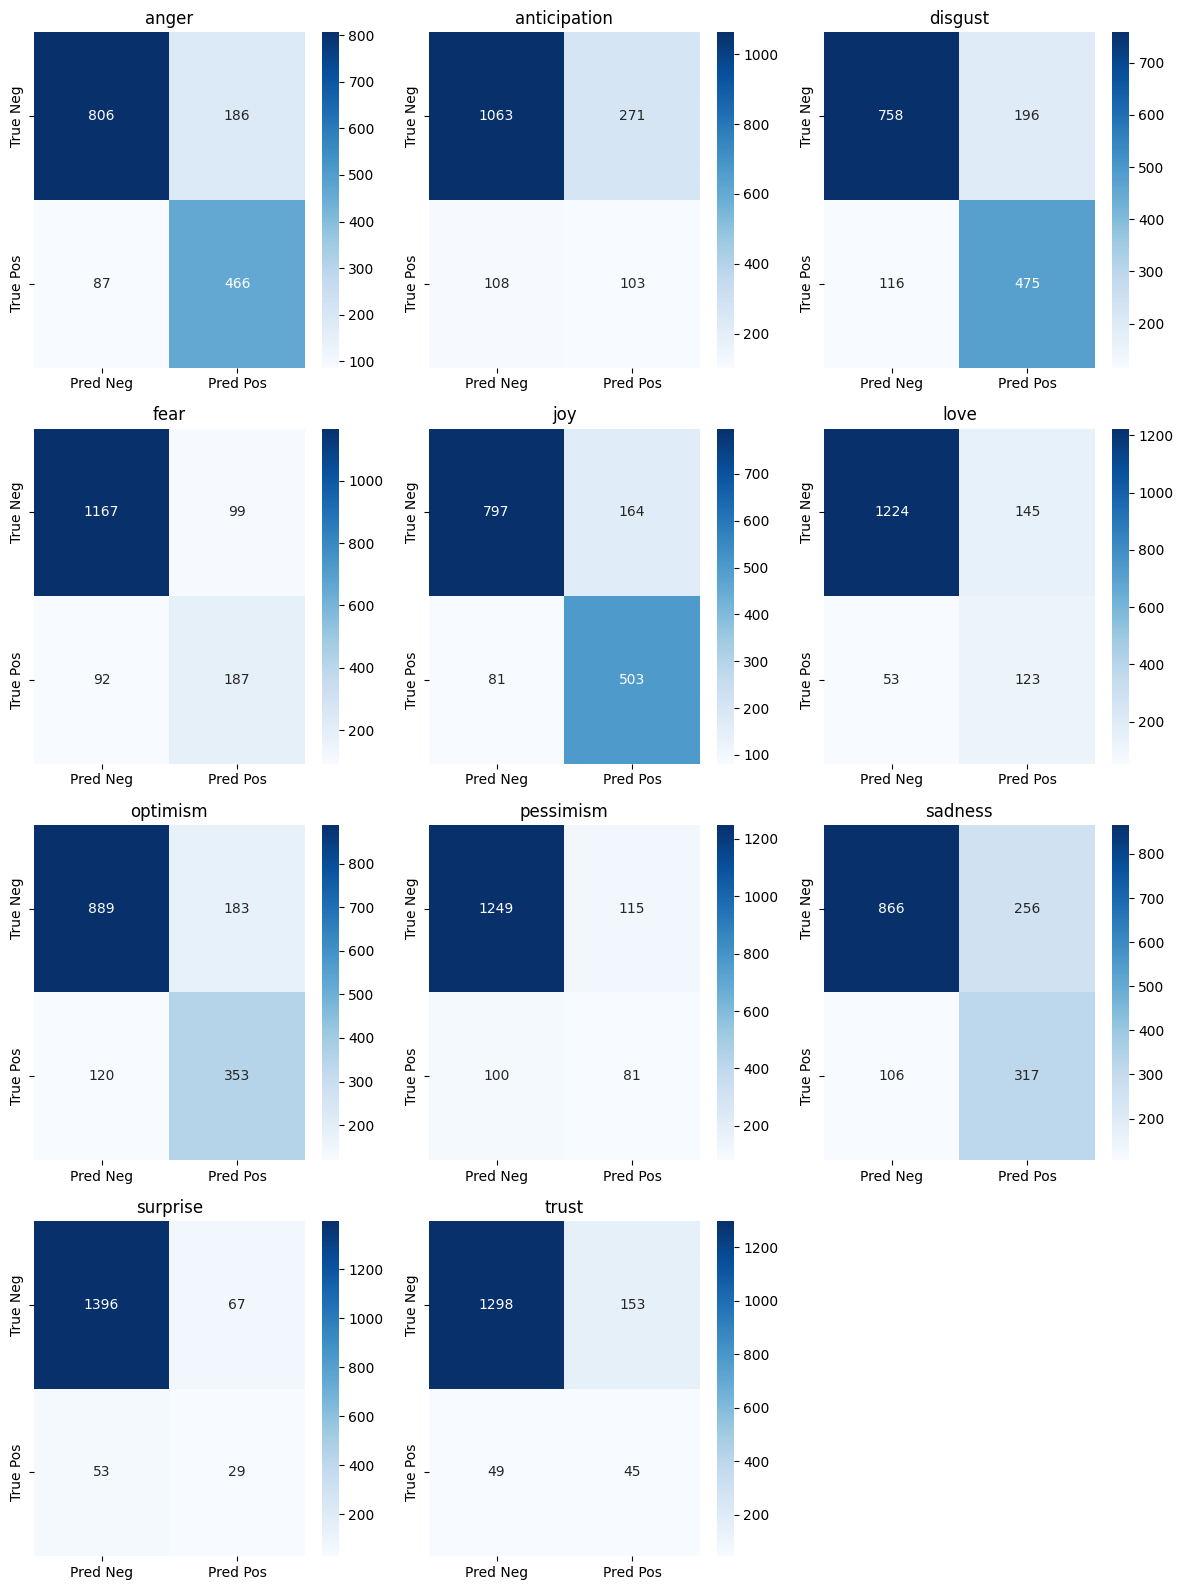

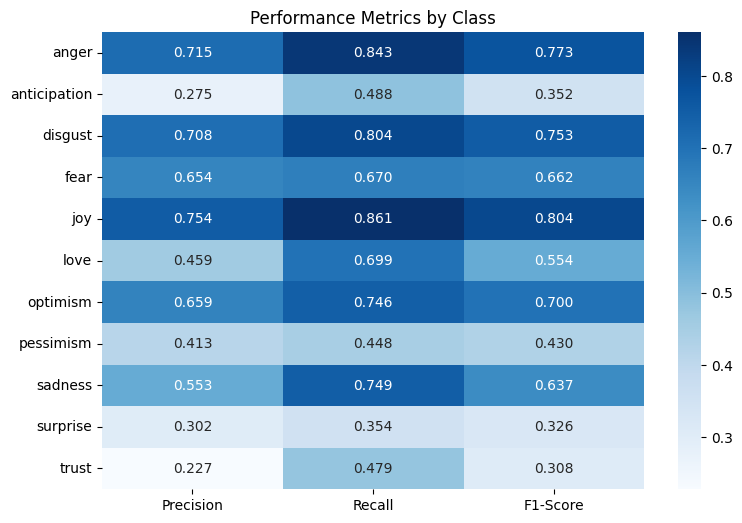

<Figure size 1200x533.333 with 0 Axes>

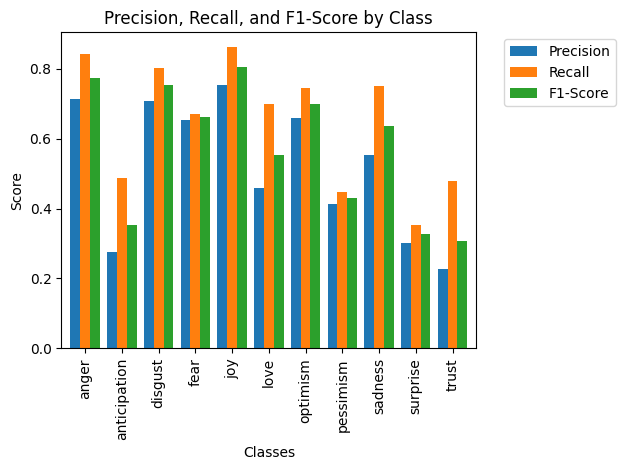

{'macro_avg': {'precision': 0.5199436407679179,
  'recall': 0.6491428476523672,
  'f1': 0.5725937000619555},
 'per_class': {'Precision': {'anger': 0.7147239263803681,
   'anticipation': 0.27540106951871657,
   'disgust': 0.7078986587183308,
   'fear': 0.6538461538461539,
   'joy': 0.7541229385307346,
   'love': 0.458955223880597,
   'optimism': 0.6585820895522388,
   'pessimism': 0.413265306122449,
   'sadness': 0.5532286212914486,
   'surprise': 0.3020833333333333,
   'trust': 0.22727272727272727},
  'Recall': {'anger': 0.8426763110307414,
   'anticipation': 0.4881516587677725,
   'disgust': 0.8037225042301185,
   'fear': 0.6702508960573477,
   'joy': 0.8613013698630136,
   'love': 0.6988636363636364,
   'optimism': 0.7463002114164905,
   'pessimism': 0.44751381215469616,
   'sadness': 0.7494089834515366,
   'surprise': 0.35365853658536583,
   'trust': 0.4787234042553192},
  'F1-Score': {'anger': 0.7734439834024897,
   'anticipation': 0.35213675213675216,
   'disgust': 0.7527733755942

In [60]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

In [61]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 380.


In [62]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/gemma_lora_imb/checkpoint-380'

In [63]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [64]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 3. Set model to evaluation mode
model.eval()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-chat-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
          

In [65]:
from datasets import Dataset

# Convert the test DataFrame to a Dataset
test_dataset = Dataset.from_pandas(test_df)

# Define the tokenization function
def tokenize_fn(batch):
    return tokenizer(batch["Tweet"], truncation=True, max_length=512)

# Tokenize the test dataset
test_set_tokenized = test_dataset.map(tokenize_fn, batched=True)

# Inspect the tokenized dataset
print(test_set_tokenized)


Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'input_ids', 'attention_mask'],
    num_rows: 3259
})


In [66]:
test_set_tokenized

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'input_ids', 'attention_mask'],
    num_rows: 3259
})

In [67]:
print(test_set_tokenized[0])


{'ID': '2018-01559', 'Tweet': '@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell', 'anger': 'NONE', 'anticipation': 'NONE', 'disgust': 'NONE', 'fear': 'NONE', 'joy': 'NONE', 'love': 'NONE', 'optimism': 'NONE', 'pessimism': 'NONE', 'sadness': 'NONE', 'surprise': 'NONE', 'trust': 'NONE', 'input_ids': [1, 732, 3253, 13707, 1649, 29955, 29947, 29953, 1649, 732, 2887, 3492, 3664, 29956, 728, 360, 609, 15982, 7560, 9987, 338, 373, 967, 5837, 304, 13916, 599, 323, 2704, 2879, 304, 19339], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [68]:
# Replace 'NONE' with 0 and combine labels into a single column
def combine_labels(row):
    def replace_none(value):
        return 0 if value == 'NONE' else int(value)

    return [replace_none(row["anger"]), replace_none(row["anticipation"]),
            replace_none(row["disgust"]), replace_none(row["fear"]),
            replace_none(row["joy"]), replace_none(row["love"]),
            replace_none(row["optimism"]), replace_none(row["pessimism"]),
            replace_none(row["sadness"]), replace_none(row["surprise"]),
            replace_none(row["trust"])]

# Apply the function to create 'labels'
test_set_tokenized = test_set_tokenized.map(lambda x: {"labels": combine_labels(x)})

# Convert labels to float tensors
test_set_tokenized = test_set_tokenized.map(
    lambda x: {"labels": torch.tensor(x["labels"]).to(torch.float)}
)

# Remove individual label columns
test_set_tokenized = test_set_tokenized.remove_columns(
    ["anger", "anticipation", "disgust", "fear", "joy", "love",
     "optimism", "pessimism", "sadness", "surprise", "trust"]
)

# Set format for PyTorch
test_set_tokenized.set_format(type="torch")

# Inspect the processed dataset
print(test_set_tokenized[0])


Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

{'ID': '2018-01559', 'Tweet': '@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell', 'input_ids': tensor([    1,   732,  3253, 13707,  1649, 29955, 29947, 29953,  1649,   732,
         2887,  3492,  3664, 29956,   728,   360,   609, 15982,  7560,  9987,
          338,   373,   967,  5837,   304, 13916,   599,   323,  2704,  2879,
          304, 19339]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


In [69]:
training_args = TrainingArguments(
    seed = 42,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [70]:
from functools import partial

In [71]:
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [74]:
# Ensure the tokenizer has a padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use eos_token if available

# If no eos_token, add a new padding token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))  # Resize model embeddings

# Ensure the model configuration also includes the padding token
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.pad_token_id

trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-74-ae23a6d83822>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [75]:
test_results= trainer.evaluate()

In [76]:
test_results

{'eval_loss': 0.7913118004798889,
 'eval_model_preparation_time': 0.0089,
 'eval_f1_micro': 0.0,
 'eval_f1_macro': 0.0,
 'eval_accuracy_label': 0.7276074646433652,
 'eval_accuracy_all': 0.0021478981282602025,
 'eval_runtime': 177.1957,
 'eval_samples_per_second': 18.392,
 'eval_steps_per_second': 0.147}

In [77]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"], "test_accuracy": test_results["eval_accuracy_all"]})

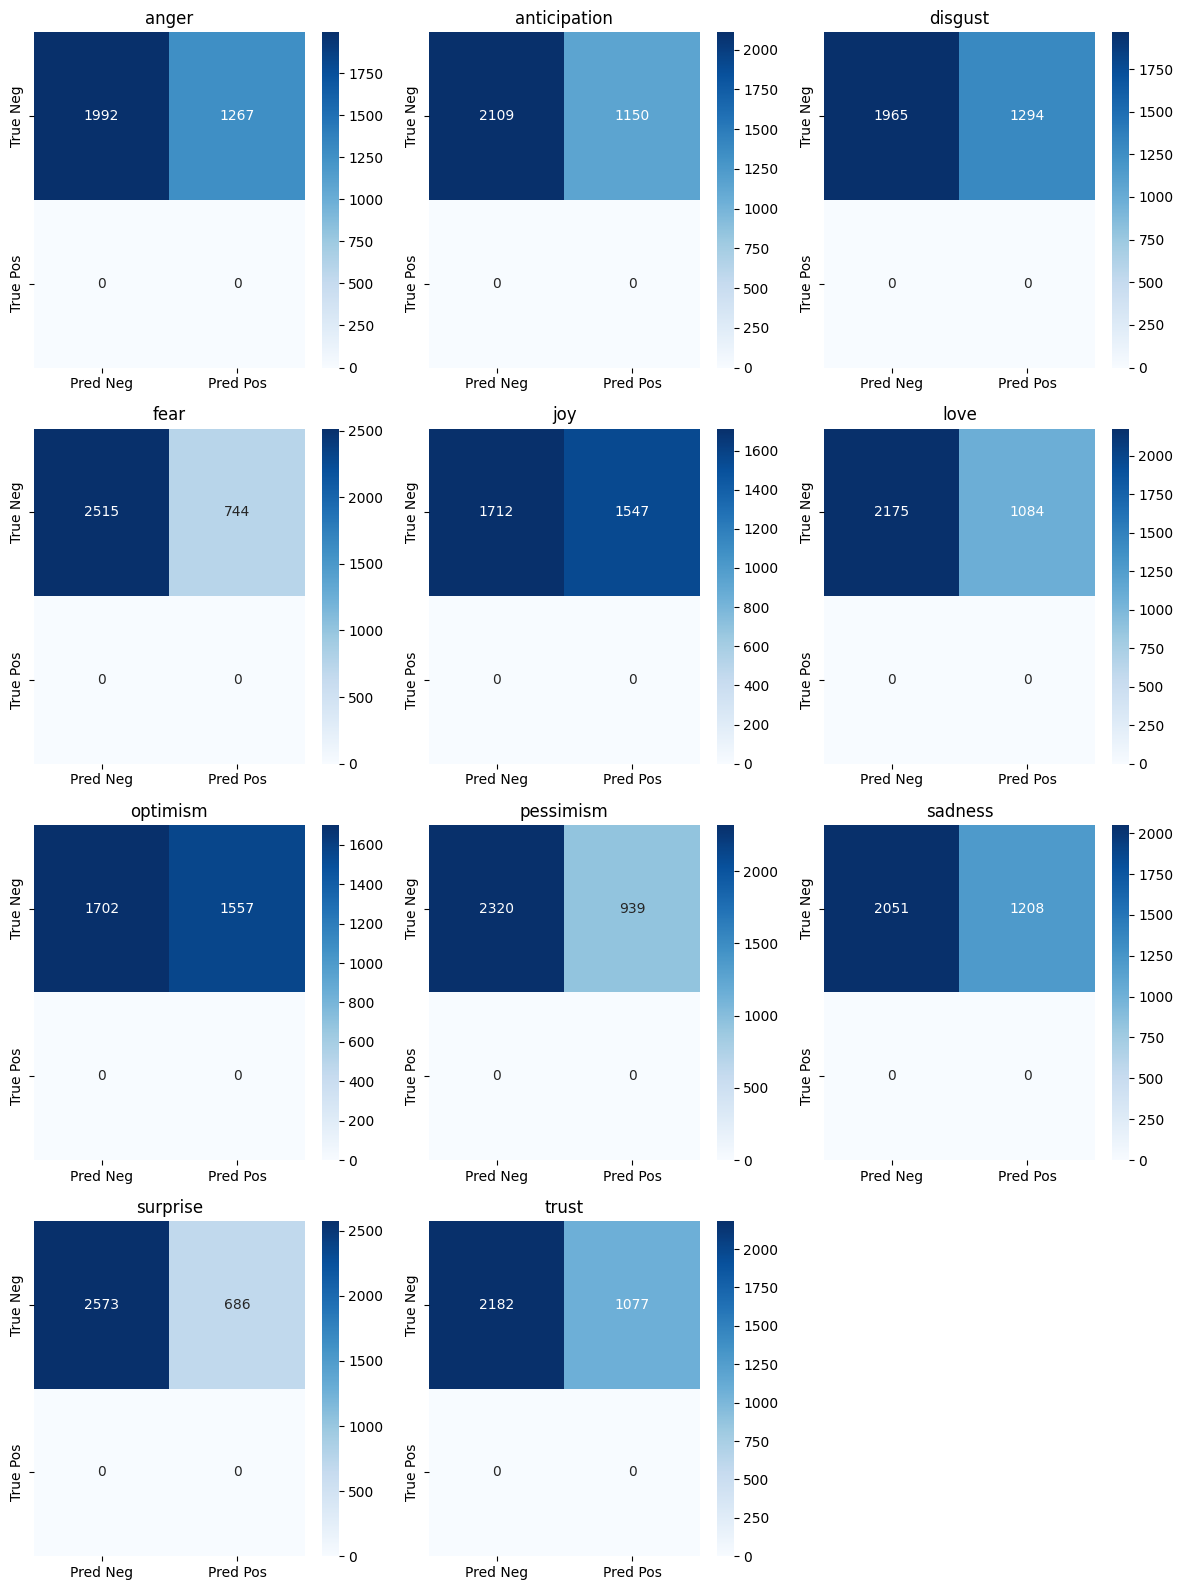

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


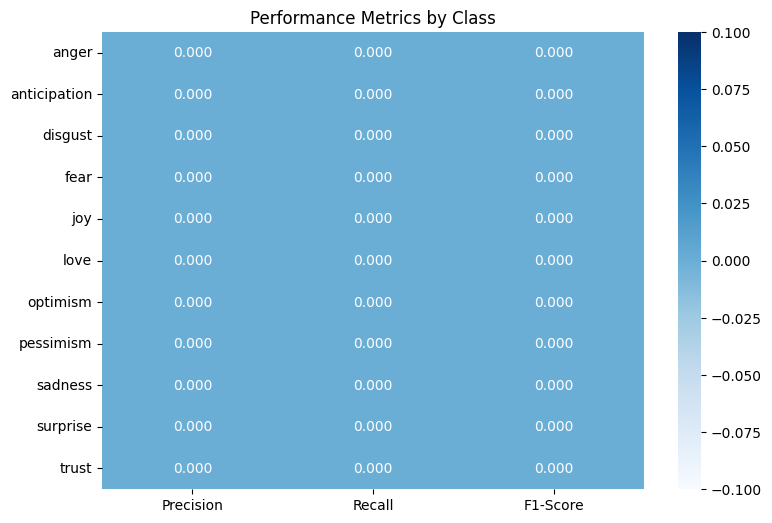

<Figure size 1200x533.333 with 0 Axes>

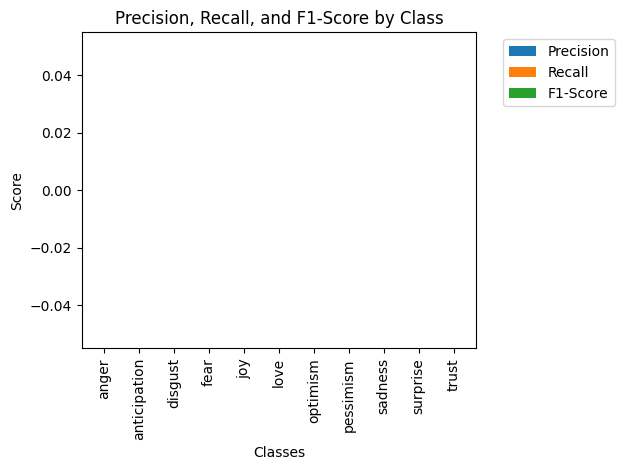

eval/accuracy_all,▁▁▁▁▂▂▂▂▄▅█▅█▇▇▇████
eval/accuracy_label,▁▁▃▃▄▅▆▅▇▇█▇██▇█████
eval/f1_macro,▁▁▂▃▄▅▆▆▇▇▇▇████████
eval/f1_micro,▁▁▂▂▄▅▅▆▇▇█▇██▇█████
eval/loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
eval/runtime,▁▄▅▅▇▆▄▅█▇▂▃▅▅▅▄▅▄▄▂
eval/samples_per_second,█▅▄▄▂▃▅▄▁▂▇▆▄▄▄▅▄▅▅▇
eval/steps_per_second,██▁▁▁▁█▁▁▁██▁▁▁█████
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


           ID  anger  anticipation  disgust  fear  joy  love  optimism  \
0  2018-01559      1             0        1     1    0     0         1   
1  2018-03739      0             1        1     1    0     0         0   
2  2018-00385      1             0        1     0    0     0         0   
3  2018-03001      0             0        0     1    0     0         0   
4  2018-01988      0             0        0     1    0     0         0   

   pessimism  sadness  surprise  trust  
0          0        0         0      0  
1          1        0         0      1  
2          1        1         0      0  
3          1        1         0      0  
4          1        1         0      0  
Submission file created successfully!


In [80]:
import numpy as np
import pandas as pd
import wandb

# Load your test data (ensure it contains an 'ID' column)
test_data = pd.read_csv('test.csv')
assert 'ID' in test_data.columns, "The test data must contain an 'ID' column."

# Make predictions using the trainer
test_output = trainer.predict(test_set_tokenized)

# Convert predictions to binary
test_preds = (test_output.predictions > 0).astype(int)
test_labels = test_output.label_ids.astype(int)

# Evaluate the model
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
               'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=class_names, figsize=(12, 8))

# Finalize WandB run
wandb.finish()

# Define label columns
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Create a DataFrame for predictions
test_predictions_binary = pd.DataFrame(test_preds, columns=label_columns)

# Prepare the submission DataFrame with 'ID' and prediction columns
submission = pd.DataFrame({
    'ID': test_data['ID'],
    **{label: test_predictions_binary[label] for label in label_columns}
})

# Optional: Verify the first few rows
print(submission.head())

# Save the submission file without the index
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
